#### imports

In [57]:
# SSIM para os histogramas 
# constancia de cor, erro angular
# universal constancia cor

In [58]:
# !conda install numba -y

In [59]:
import os
import cv2
from sklearn.cluster import k_means, KMeans
# from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
import numpy as np
from numba import njit

import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics.cluster import adjusted_rand_score #, ran
# from sklearn import datasets
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Pre-processing

In [60]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  
  def read_dataset(self, filename):
    X = pd.read_csv(filename, header=None, delim_whitespace=True)
    y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
    return X, y
  def fit(self, X, y):
    return self
  
  def transform(self, X: pd.DataFrame, y=pd.DataFrame):
    y_lenth = len(y)
    if y_lenth:
      # key = "class"
      # y = pd.DataFrame({key: y})
      values = pd.concat([X, y], axis=1)
    else:
      values = X.copy()

    values = values.dropna()
    values = values.drop_duplicates()
    if y_lenth:
      return values[X.columns.values], values[values.columns.values[-1]]
    return values
  
  def fit_transform(self, X, y=pd.DataFrame):
      return self.fit(X, y).transform(X, y)
  
class Transformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if type(X) == np.ndarray:
      return X
    return X.values
  def fit_transform(self, X, y=None):
    return self.fit(X, y).transform(X, y)

### Model

##### Metrics

In [61]:
def uqi(img1, img2):
    """
    Calculate the Universal Quality Image Index (UQI) between two images.

    Parameters:
    img1 (numpy array): First image (reference image).
    img2 (numpy array): Second image (image to be compared).

    Returns:
    float: UQI value between -1 and 1.
    """
    assert img1.shape == img2.shape, "Images must have the same dimensions"
    
    N = img1.size
    
    # Means
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)
    
    # Variances and covariance
    var1 = np.var(img1)
    var2 = np.var(img2)
    covar = np.mean((img1 - mean1) * (img2 - mean2))
    
    # UQI calculation
    numerator = 4 * covar * mean1 * mean2
    denominator = (var1 + var2) * (mean1**2 + mean2**2)
    
    if denominator == 0:
        return 1 if numerator == 0 else 0
    
    uqi_value = numerator / denominator
    return uqi_value

def calculate_histogram(image, bins=256):
    """
    Calculate the histogram of an image.
    
    Parameters:
    image (numpy array): Input image.
    bins (int): Number of bins for the histogram.
    
    Returns:
    numpy array: Histogram of the image.
    """
    hist = [cv2.calcHist(images=[image], channels=[channel], mask=None, histSize = [bins], ranges=[0, 256]) \
            for channel in range(3)]
    # hist = cv2.normalize(hist, hist).flatten()
    return hist

def ssim_histogram(hist1, hist2, C1=1e-4, C2=9e-4):
    """
    Calculate SSIM between two histograms.
    
    Parameters:
    hist1 (numpy array): Histogram of the first image.
    hist2 (numpy array): Histogram of the second image.
    C1 (float): Constant to avoid division by zero.
    C2 (float): Constant to avoid division by zero.
    
    Returns:
    float: SSIM value.
    """
    def hist_ssim(hist1, hist2):
        mu_x = np.mean(hist1)
        mu_y = np.mean(hist2)
        sigma_x = np.var(hist1)
        sigma_y = np.var(hist2)
        sigma_xy = np.mean((hist1 - mu_x) * (hist2 - mu_y))
        
        return ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2))
    
 
    hssim = [hist_ssim(hist1[channel], hist2[channel]) for channel in range(3)]
    
    return np.mean(hssim)

def metricas(image1, image2):
    uqi_value = uqi(image1, image2)

    hist1 = calculate_histogram(image1)
    hist2 = calculate_histogram(image2)

    # Calcular SSIM entre histogramas
    ssim = ssim_histogram(image1, image2)
    hssim = ssim_histogram(hist1, hist2)
    print(f"SSIM : {ssim:.4f}")
    print(f"SSIM entre histogramas: {hssim:.4f}")
    print(f"UQI: {uqi_value:.4f}")
    return ssim, hssim, uqi_value

In [62]:
class Gaussian:
  def distance(self, g, x, sigma):
    if x.shape[0] == 0 or sigma.shape[0] == 0:
      raise Exception
    distance = np.square(np.subtract(x, g)) #**2
    distance_sigma = distance / sigma
    summatory_distance = (-1/2)*np.sum(distance_sigma, 1)
    return np.exp(summatory_distance)

class Metrics:
  def mpc(u: np.array):
    # modified partition coefficient
    n, k = u.shape
    f = np.trace(u.dot(u.T)) / n

    mpc = 1 - (k/(k - 1))*(1 - f)
    return mpc
  def ars(y_true, y_pred):
    # adjusted rand score
    return adjusted_rand_score(y_true, y_pred)

##### Shower

In [63]:
class Shower:
    def show_grafico(self, x):
        _, axes = plt.subplots()
        markers = ["^", "x", "+"]
        p = self.predict(self.G, x)

        for c, (x_1, x_2) in zip(p, x):
            r, g, b, a = (
                0.9 * ((c + 1) / self.num_class),
                0.9 * ((c * 1.1) / self.num_class),
                0.9 * ((c * 1.2) / self.num_class),
                0.1,
            )

            axes.plot(x_1, x_2, "ro", marker=markers[c])

        raio = self.distance_classes() / 2

        for i, (x_1, x_2) in enumerate(self.G):

            plt.plot(x_1, x_2, "go", scalex=0.01, scaley=0.01)
            r, g, b, a = (
                0.9 * ((i + 1) / self.num_class),
                0.9 * ((i * 1.1) / self.num_class),
                0.9 * ((i * 1.2) / self.num_class),
                0.9,
            )
            c = plt.Circle((x_1, x_2), raio, color=(r, g, b, a), fill=False)

            axes.set_aspect(aspect=1, adjustable="datalim", anchor="SW")
            axes.add_artist(c)
        plt.show()

    def show_function_objetive(self, data_f, params):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

        # plot box plot
        axs[0].boxplot(data_f)
        # axs[0].set_title('funcão objetivo e m ')
        axs[0].yaxis.grid(True)
        axs[0].set_xticks([y + 1 for y in range(len(data_f))], labels=params)
        axs[0].set_xlabel("m")
        axs[0].set_ylabel("f")

        plt.show()

    def show_labels(self, x, filename):
        # Data
        k, n = x.shape
        plt.figure(figsize=(20, 6))

        # Labels
        xlabs = np.arange(k)
        ylabs = np.arange(n)

        # Heat map
        _, ax = plt.subplots(constrained_layout=True)

        # ax.figure()
        ax.set_axis_off()  # = [0.1, 0.1, 0.8, 0.8] #.add_axes()
        ax.imshow(x)
        if n < 10:
            # Add the labels
            ax.set_xticks(ylabs)
            ax.set_yticks(xlabs)

            # Add the values to each cell
            for i in range(len(xlabs)):
                for j in range(len(ylabs)):
                    _ = ax.text(
                        j,
                        i,
                        round(x[i, j], 1),
                        ha="center",
                        va="center",
                        color=(0, 0, 0),
                    )  # "w"
        if filename:
            plt.savefig(filename, dpi=150)
        plt.show()

    def show_G_S(self, folder):
        # show the values of Gs and S(widths)
        if not os.path.isdir(folder):
            os.makedirs(folder)
        print("Gs")
        self.show_labels(self.G, f"{folder}/G")
        print("S2s")
        self.show_labels(self.sigma, f"{folder}/sigma")

##### Base Model

In [64]:
class Model:
    def __init__(self, loss=Gaussian(), var_type=np.float32) -> None:
        # model base
        self.loss = loss
        np.float32 = var_type

    def predict(self, X, is_preprocessing=False, argmax=True):
        # here we make predict in x
        n = X.shape[0]
        k = self.G.shape[0]

        if is_preprocessing:
            X = self.preprocesssing(X)
        u = np.zeros((n, k), np.float32)

        distances = np.array(
            [2 - 2 * self.loss.distance(self.G[i], X, self.sigma[i]) for i in range(k)]
        ).T

        expoente = 1 / (self.m - 1)

        for i in range(n):

            ds = distances[i] == 0
            if (ds).any():
                summation_c_i_1 = np.zeros((k))
                summation_c_i_1[ds] = 1
            else:
                summation_c = np.array(
                    [((distances[i] / distances[i, h]) ** expoente) for h in range(k)]
                )  # .T

                summation_c_i = np.sum(summation_c, 0)
                summation_c_i_1 = np.power(summation_c_i, -1)

            u[i] = summation_c_i_1.copy()
        if argmax:
            return u.argmax(1)
        return u
        # if argmax:

    def set_g(self, g):
        self.G = g.copy()

    def set_sigma(self, sigma):
        self.sigma = sigma.copy()

    def preprocesssing(self, X):
        pipeline = Pipeline(
            [
                ("MinMaxScaler", MinMaxScaler()),
                ("Transformer", Transformer()),
            ]
        )

        return pipeline.transform(X)

    def save_model(self, filename):
        # Save the model in json file
        json_object = json.dumps(
            {"G": self.G.tolist(), "sigma": self.sigma.tolist(), "m": self.m}, indent=2
        )  #
        # Writing to sample.json
        folder = "/".join(filename.split("/")[:-1])
        if not os.path.isdir(folder):
            os.makedirs(folder)

        with open(filename, "w") as outfile:
            outfile.write(json_object)

    def load_model(self, filename):
        # Reading from json file
        with open(filename, "r") as openfile:
            json_object = json.load(openfile)
            self.G = np.array(json_object["G"])
            self.sigma = np.array(json_object["sigma"])
            self.m = json_object["m"]


##### FuzzyCMeansGaussianS2

In [65]:
a = np.random.rand((2048*2048)).reshape((2048,2048))
b = np.random.rand((2048*2048)).reshape((2048,2048))

In [66]:
np.square(
    np.multiply(np.multiply(a, np.multiply(b, a)), np.multiply(b, np.multiply(a, b)))
)

array([[2.43305220e-08, 1.90253849e-04, 4.35782975e-04, ...,
        1.24096672e-11, 7.95390769e-03, 7.40112391e-03],
       [1.65870485e-02, 2.83923551e-03, 9.64419571e-07, ...,
        6.89081633e-04, 2.71011561e-08, 4.66518107e-03],
       [3.80511974e-06, 3.21005693e-02, 2.09675551e-03, ...,
        5.67416087e-03, 5.51658180e-03, 6.68198869e-11],
       ...,
       [8.54757660e-04, 3.27805190e-02, 5.00936830e-06, ...,
        4.48236565e-09, 1.35760757e-03, 7.32246703e-04],
       [3.04995279e-04, 1.98598390e-09, 1.13939082e-01, ...,
        1.66436980e-14, 4.38440214e-06, 2.03287862e-06],
       [4.10533993e-03, 4.54536859e-04, 5.71251324e-07, ...,
        3.99760201e-02, 4.00370875e-09, 2.62500969e-01]])

In [67]:
a*b*a*b*a*b**2

array([[2.46163568e-05, 9.16729741e-03, 1.16697588e-02, ...,
        2.14937187e-06, 5.63852346e-02, 4.00893306e-02],
       [9.39099684e-02, 4.90897966e-02, 5.50248880e-04, ...,
        2.07011501e-02, 8.87610996e-05, 3.03975630e-02],
       [3.42598908e-04, 1.02129946e-01, 2.10081733e-02, ...,
        3.78362684e-02, 6.03368690e-02, 6.36037222e-06],
       ...,
       [1.05766483e-02, 1.54186064e-01, 8.81445864e-04, ...,
        1.23720879e-05, 1.72621802e-02, 1.37653041e-02],
       [9.29697966e-03, 1.01810219e-05, 2.49727349e-01, ...,
        3.09334164e-09, 5.01818774e-04, 2.35817766e-04],
       [6.11942816e-02, 1.61334603e-02, 3.62113591e-04, ...,
        1.79371027e-01, 5.60886654e-06, 4.39905384e-01]])

In [68]:
print(np.dot(a, b))

[[509.339298   500.72221506 511.36611436 ... 512.16371691 503.13054011
  511.97213476]
 [509.77038478 510.42614851 512.99533251 ... 506.73884062 519.25279554
  511.70517975]
 [505.45509228 506.33016095 513.51966356 ... 506.05197574 518.2967963
  506.04624519]
 ...
 [506.36091914 507.99253852 518.77363524 ... 511.41933037 512.27017898
  507.52408044]
 [505.40060615 514.71182032 518.02236505 ... 509.77841676 515.78299097
  511.36748651]
 [501.79420476 504.57664246 506.76197493 ... 503.04588192 510.55607406
  508.42743245]]


In [69]:
import numpy as np
from multiprocessing import Pool

def process_array_chunk(chunk):
    return chunk * 2 + np.sin(chunk)

data = np.random.rand(1000)
# chunks = np.array_split(data, 4)

# with Pool(processes=4) as pool:
#     result = pool.map(process_array_chunk, chunks)

# result = np.concatenate(result)
process_array_chunk(data)

array([7.21332125e-01, 2.28219400e+00, 1.07191683e+00, 2.37080649e+00,
       1.87531672e+00, 4.91937109e-01, 1.03364858e+00, 1.20619481e+00,
       5.23816736e-01, 9.50248132e-01, 1.95221623e+00, 1.99090853e-01,
       2.24855573e+00, 2.15998291e+00, 2.63119968e+00, 2.25566187e+00,
       9.65721125e-01, 2.74004395e+00, 2.74226214e+00, 1.11260110e+00,
       1.68561396e-01, 2.05226027e+00, 3.15542628e-01, 2.64927192e+00,
       2.12538271e+00, 2.44018462e+00, 8.80371398e-01, 9.27470308e-01,
       2.27205860e+00, 2.08443077e+00, 4.45484544e-01, 2.48663021e+00,
       1.95847495e+00, 2.21165510e+00, 2.66108944e+00, 2.79478695e+00,
       1.16476933e+00, 1.34889250e+00, 1.43957346e+00, 2.65581395e-01,
       2.59021943e+00, 1.59752290e+00, 1.78034731e+00, 2.80409925e+00,
       1.64807031e+00, 2.11948348e+00, 1.76540319e+00, 1.77640283e+00,
       7.97098174e-01, 2.50364131e+00, 1.78943618e+00, 2.02872626e+00,
       3.10154633e-01, 2.15442817e+00, 2.44348086e+00, 1.53464415e+00,
      

In [70]:
# tá funcionando bonitinho

class FuzzyCMeansGaussianS2(Shower, Model):
    def __init__(
        self,
        num_class,
        epochs,
        threshold,
        loss=Gaussian(),
        m=1.1,
        seeder=None,
        verbose=False,
    ) -> None:
        # load the hiperparams
        super().__init__(loss=loss, var_type=np.float32)
        self.num_class = num_class
        self.m = m
        self.verbose = verbose
        if seeder:
            self.seeder = seeder
            np.random.seed(seeder)

        self.threshold = threshold
        self.epochs = epochs
    # @njit
    def init_g(self, x):
        # here we get random prototipes to train
        args = np.random.choice(x.shape[0], self.num_class, replace=False)
        self.G = x[args].copy()
    # @njit
    def init_u(self, x):
        # we calcule initial matrix of membership
        g = self.G.copy()
        sigma = self.sigma.copy()
        self.n = x.shape[0]
        self.k = g.shape[0]

        self.U = np.zeros((self.n, self.k), np.float32)

        distances = np.array(
            [2 - 2 * self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]
        ).T

        expoente = 1 / (self.m - 1)

        for i in range(self.n):
            # summation_c = np.array([(distances[i, h] / distances[i])**expoente for h in range(self.k)])
            # np.divide
            # summation_c = np.array([(distances[i] / distances[i, h])**expoente for h in range(self.k)]) #.T
            ds = distances[i] == 0
            if (ds).any():
                summation_c_i_1 = np.zeros((self.k))
                summation_c_i_1[ds] = 1
                self.U[i] = summation_c_i_1.copy()

            else:
                summation_c = np.array(
                    [
                        ((distances[i] / distances[i, h]) ** expoente)
                        for h in range(self.k)
                    ]
                )  # .T

                summation_c_i = np.sum(summation_c, 0)
                summation_c_i_1 = np.power(summation_c_i, -1)

                membership_is_nan = np.isnan(summation_c_i_1)

                summation_u = np.sum(summation_c_i_1, where=membership_is_nan == False)

                summation_u_1 = 1 - summation_u
                abs_summation_u_1 = np.abs(summation_u_1)

                if abs_summation_u_1 > 0.01:
                    arg = summation_c_i_1.argmax()
                    summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1

                    self.U[i] = summation_c_i_1.copy()
                else:
                    self.U[i] = summation_c_i_1.copy()
    # @njit
    def init_sigma(self, x):
        # we calcule initial matrix of widths each 1
        self.p = x.shape[1]
        self.k = self.G.shape[0]
        self.sigma = np.ones((self.k, self.p), dtype=np.float32)

    # passo 1
    # @njit 
    def otm_prototivo(self, g, u, x, sigma):
        new_g = g.copy()
        u_i = u**self.m

        for i in range(self.k):
            n_g = self.loss.distance(g[i], x, sigma[i])

            u_m_g = u_i[:, i] * n_g  # *
            u_m_gx = ((x.T) * u_m_g).T

            s_umg = np.sum(u_m_g)
            s_umgx = np.sum(u_m_gx, 0)

            new_g[i] = s_umgx / s_umg
        return new_g

    # passo 2
    # @njit 
    def otm_u(self, g, x, sigma):
        new_u = np.zeros((self.n, self.k), dtype=np.float32)

        distances = np.array(
            [2 - 2 * self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]
        ).T

        expoente = 1 / (self.m - 1)
        for i in range(self.n):

            ds = distances[i] == 0
            if (ds).any():
                summation_c_i_1 = np.zeros((self.k))
                summation_c_i_1[ds] = 1
                new_u[i] = summation_c_i_1.copy()

            else:
                summation_c = np.array(
                    [
                        ((distances[i] / distances[i, h]) ** expoente)
                        for h in range(self.k)
                    ]
                )  # .T

                summation_c_i = np.sum(summation_c, 0)

                summation_c_i_1 = np.power(summation_c_i, -1)

                membership_is_nan = np.isnan(summation_c_i_1)

                summation_u = np.sum(summation_c_i_1, where=membership_is_nan == False)

                summation_u_1 = 1 - summation_u
                abs_summation_u_1 = np.abs(summation_u_1)
                # if

                if summation_u == 0 or membership_is_nan.any():
                    count = np.sum(membership_is_nan)  # total nan
                    new_u[i] = np.nan_to_num(summation_c_i_1, nan=summation_u_1 / count)
                elif abs_summation_u_1 > 0.01:
                    arg = summation_c_i_1.argmax()
                    summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1

                    new_u[i] = summation_c_i_1.copy()
                else:
                    new_u[i] = summation_c_i_1.copy()
        return new_u
    
    # @njit 
    def otm_sigma(self, x, g, u):
        s = self.sigma.copy()

        ui = u ** (self.m)

        for i in range(self.k):
            g_i = g[i]
            ui_per = ui[:, i]

            g_d = self.loss.distance(g_i, x, s[i])
            e_d = (x - g_i) ** 2

            s_cn = e_d.T * (ui_per * g_d)

            if s_cn.shape[1] != 1:
                ss_cn = np.sum(s_cn, 1).copy()
            else:
                ss_cn = np.squeeze(s_cn, 1).copy()

            s_p = np.prod(ss_cn)
            s_p = s_p ** (1 / self.p)

            s_ij = s_p / ss_cn

            r_r = s_ij[np.isnan(s_ij) == False]
            p_r = np.prod(r_r)

            s_r = np.abs(1 - p_r)

            # verificacao do produtorio para a classe que deve ser 1
            if p_r == 0:
                teste = False

                if teste:
                    m_s = np.sum(ss_cn) / (self.p)

                # ss_cn = ss_cn*(1/m_s)
                if teste:
                    im_s = 1 / (m_s)
                    new_ss_cn = ss_cn * im_s
                else:
                    new_ss_cn = 1 - ss_cn  # **(1/(self.p))

                new_s_p = np.prod(new_ss_cn)

                new_s_p = new_s_p ** (1 / self.p)

                new_r = new_s_p / new_ss_cn

                prod = np.prod(new_r)

                if np.isnan(prod) == False:
                    s[i] = new_r.copy()

            elif s_r > 0.1:
                # para quando o produtorio de Ss dá diferente de 1
                if r_r.shape[0] == s_ij.shape[0]:
                    s[i] = s_ij / (p_r ** (1 / s_ij.shape[0]))
                else:
                    s_prod = 1 / (p_r ** (1 / s_ij.shape[0]))
                    s[i] = np.nan_to_num(s_ij, copy=True, nan=s_prod)
            else:
                s[i] = s_ij.copy()

        return s
    
    # @njit 
    def funcao_objetivo(self, x, g, u, sigma):
        # k = g.shape[0]
        u_i = u**self.m
        f = np.zeros(self.k, dtype=np.float32)

        s_d = np.zeros(x.shape[0], dtype=np.float32)
        w = np.zeros(x.shape[0], dtype=np.float32)
        for i in range(self.k):
            s_d = 2 - 2 * self.loss.distance(g[i], x, sigma[i])

            w = s_d.T * (u_i[:, i])
            f[i] = np.sum(w)

        return np.sum(f)
    
    # @njit 
    def atualiza_GUS2(self, g, u, sigma):
        self.G = g
        self.U = u
        self.sigma = sigma
    
    # @njit 
    def fit(self, x, y, verbose=False):
        self.redu = True

        self.init_g(x)
        self.init_sigma(x)
        self.init_u(x)

        j = self.funcao_objetivo(x, self.G, self.U, self.sigma)
        if self.verbose:
            print("epoca:", 0, "funcão objetivo:", j)  # , new_f

        for epoch in range(self.epochs):
            # "passo 1"
            new_sigma = self.otm_sigma(x, self.G, self.U)

            # "passo 2"
            new_g = self.otm_prototivo(self.G, self.U, x, new_sigma)

            # "passo 3"
            new_u = self.otm_u(new_g, x, new_sigma)

            new_j = self.funcao_objetivo(x, new_g, new_u, new_sigma)
            if self.verbose:
                print(f"epoca: {epoch + 1} funcão objetivo: {new_j}")  # f,
                # print(
                #     f"Modified partition coefficient  {Metrics.mpc(self.U)},  {Metrics.ars(y, self.U.argmax(1))}"
                # )  # f,

            # silhouette_score
            if verbose:
                self.show_grafico(x)

            dif = np.abs(new_j - j)
            # new_j > j
            if np.isnan(new_j) == True or dif < self.threshold:
                return
            else:
                j = new_j
                self.atualiza_GUS2(new_g, new_u, new_sigma)


##### Trainer

In [71]:
class Trainer(FuzzyCMeansGaussianS2):
    def __init__(
        self,
        num_class,
        epochs,
        threshold,
        model_creator,
        filename,
        loss=Gaussian(),
        m=1.1,
        verbose=False,
        repeat=1,
    ) -> None:
        # load the hiperparams
        super().__init__(num_class, epochs, threshold, loss=loss, m=m)
        self.num_class = num_class
        np.float32 = np.float32
        self.verbose = verbose
        self.threshold = threshold
        self.epochs = epochs
        self.repeat = repeat
        self.model_creator = model_creator
        self.filename = filename
        self.metrics = {
            "objetive_function": [],
            "mpc": [],
            "ars": [],
        }

    def fit(self, X, y):
        j = np.inf

        for i in range(self.repeat):
            model = self.model_creator(
                num_class=self.num_class,
                epochs=self.epochs,
                threshold=self.threshold,
                loss=self.loss,
                m=self.m,
                verbose=self.verbose,
            )
            model._only = False
            model.fit(X, y)
            new_j = model.funcao_objetivo(X, model.G, model.U, model.sigma)
            new_mpc = Metrics.mpc(model.U)
            new_ars = Metrics.ars(y, model.U.argmax(1))

            print(f"repeation: {i + 1} funcão objetivo: {new_j}")
            print(
                f"Modified partition coefficient: {new_mpc},  adjusted rand score: {new_ars}"
            )

            self.metrics["objetive_function"].append(new_j)
            self.metrics["mpc"].append(new_mpc)
            self.metrics["ars"].append(new_ars)

            if new_j < j:
                self.G = model.G
                self.U = model.U
                self.sigma = model.sigma
                j = new_j

        self.save_model(f"./model/{self.m}/{self.filename}")
        self.save(f"./metrics/{self.m}/{self.filename}")

    def save(self, filename):
        if not len(self.metrics["objetive_function"]):
            print("the models is not fit")
            return
        # Save the model in json file
        json_object = json.dumps(self.metrics, indent=2)  #
        # Writing to sample.json
        folder = "/".join(filename.split("/")[:-1])
        if not os.path.isdir(folder):
            os.makedirs(folder)

        with open(filename, "w") as outfile:
            outfile.write(json_object)

##### Custom model

In [72]:
# Definindo a variável de ambiente temporariamente
os.environ["OMP_NUM_THREADS"] = "2"
# Classe do Modelo Personalizado
class CustomModel(BaseEstimator, ClusterMixin):
    def __init__(self, param1=1, param2=1, **kwargs):
        super(CustomModel).__init__(**kwargs)
        self.param1 = param1
        self.param2 = param2
        self.kmeans = KMeans(n_clusters=self.param1, n_init=10)

    def fit(self, X, y):
        # Implemente aqui o código para treinar o modelo com os parâmetros
        self.kmeans.fit(X, y) 
        

    def predict(self, X):
        # Implemente aqui o código para fazer previsões
        return self.kmeans.predict(X)

    def get_params(self, deep=True):
        return {'param1': self.param1, 'param2': self.param2}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Carregando o conjunto de dados Iris
# iris = load_iris()
# X = iris.data
# y = iris.target

# # Dividindo o conjunto de dados em conjuntos de treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Definindo o modelo personalizado
# custom_model = CustomModel()

# # Definindo o espaço de parâmetros a serem testados
# param_grid = {
#     'param1': list(range(1, 6)),
#     'param2': [0.1, 0.01, 0.001]
# }

# # Criando um objeto GridSearchCV com o modelo personalizado, espaço de parâmetros e métrica de avaliação
# grid_search = GridSearchCV(estimator=custom_model, param_grid=param_grid, cv=5, scoring='rand_score')

# # Ajustando o GridSearchCV aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Exibindo os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Exibindo a melhor pontuação alcançada
# print("Melhor pontuação:", grid_search.best_score_)

# # Avaliando o desempenho do modelo otimizado nos dados de teste
# accuracy = grid_search.score(X_test, y_test)
# print("Acurácia nos dados de teste:", accuracy)


### colect data

#### eBDtheque_database_v3 Page CYB_COSMOZONE

In [73]:
resultados = []

In [74]:
# from Pill import Image 
from PIL import Image #, ImageDraw, ImageFont

img_path = "./datasets/eBDtheque_database_v3/Pages/CYB_COSMOZONE_012.jpg"

image = np.array(Image.open(img_path).convert("RGB"))
# image_shape_out = 320, 320, 3
image_shape_out = image.shape

print(image.shape)
X = image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]].reshape(-1, image_shape_out[2]) /255
print(X.shape)

(661, 569, 3)
(376109, 3)


In [75]:
# image 출력 함수 정의
def show_img_bbox(X, y):
    plt.figure(figsize=(20, 20))
    for i, img in enumerate([X, y]):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)


#### c = 20

##### fit

In [76]:
model = FuzzyCMeansGaussianS2(num_class=20, epochs=50, threshold=.5, verbose=True)
model.fit(X, None)

epoca: 0 funcão objetivo: 6646.3228
epoca: 1 funcão objetivo: 6265.4287109375
epoca: 2 funcão objetivo: 4489.37744140625
epoca: 3 funcão objetivo: 3869.111328125
epoca: 4 funcão objetivo: 3648.727783203125
epoca: 5 funcão objetivo: 3559.513916015625
epoca: 6 funcão objetivo: 3423.876220703125
epoca: 7 funcão objetivo: 3473.521728515625
epoca: 8 funcão objetivo: 3391.360595703125
epoca: 9 funcão objetivo: 3419.352783203125
epoca: 10 funcão objetivo: 3374.634765625
epoca: 11 funcão objetivo: 3395.65576171875
epoca: 12 funcão objetivo: 3367.427490234375
epoca: 13 funcão objetivo: 3386.014404296875
epoca: 14 funcão objetivo: 3364.338134765625
epoca: 15 funcão objetivo: 3380.850341796875
epoca: 16 funcão objetivo: 3361.87109375
epoca: 17 funcão objetivo: 3375.8955078125
epoca: 18 funcão objetivo: 3357.983642578125
epoca: 19 funcão objetivo: 3368.770263671875
epoca: 20 funcão objetivo: 3351.830810546875
epoca: 21 funcão objetivo: 3359.695556640625
epoca: 22 funcão objetivo: 3345.10400390625


In [77]:
y = model.predict(X)

In [78]:
model.G

array([[0.99800484, 0.99701641, 0.99743569],
       [0.24453366, 0.144332  , 0.1464569 ],
       [0.67533874, 0.66593107, 0.66673572],
       [0.4083235 , 0.34853584, 0.33750511],
       [0.7934681 , 0.71182837, 0.94252929],
       [0.99800484, 0.99701641, 0.99743569],
       [0.97924482, 0.90555437, 0.68903917],
       [0.93709641, 0.91029695, 0.94261252],
       [0.71088673, 0.62670318, 0.9173549 ],
       [0.99800484, 0.99701641, 0.99743569],
       [0.82649921, 0.64146581, 0.52937098],
       [0.5971923 , 0.48719589, 0.44452342],
       [0.05367003, 0.01990066, 0.02263545],
       [0.97720997, 0.93912743, 0.58308141],
       [0.99800484, 0.99701641, 0.99743569],
       [0.99800484, 0.99701641, 0.99743569],
       [0.83725877, 0.80296472, 0.77112083],
       [0.88182397, 0.34097213, 0.32514449],
       [0.87618076, 0.80694183, 0.96084589],
       [0.99800484, 0.99701641, 0.99743569]])

In [79]:
model.sigma

array([[1.611785  , 0.486669  , 1.2748502 ],
       [0.88187927, 1.1850395 , 0.95688117],
       [0.9358299 , 0.9339528 , 1.1441374 ],
       [0.92270803, 1.1670234 , 0.9286587 ],
       [1.1482112 , 1.0634223 , 0.81897837],
       [1.611785  , 0.486669  , 1.2748502 ],
       [4.902583  , 0.9607297 , 0.21231166],
       [1.244889  , 1.138381  , 0.70563763],
       [1.267263  , 1.057886  , 0.74592364],
       [1.611785  , 0.486669  , 1.2748502 ],
       [1.189242  , 0.7203633 , 1.1672884 ],
       [1.0089391 , 1.0259464 , 0.96607393],
       [0.55272514, 1.5837427 , 1.1423683 ],
       [1.1856405 , 0.78424305, 1.0754651 ],
       [1.611785  , 0.486669  , 1.2748502 ],
       [1.611785  , 0.486669  , 1.2748502 ],
       [0.94088656, 1.2709788 , 0.8362275 ],
       [1.3838459 , 0.7743306 , 0.93322384],
       [1.1364343 , 0.88518924, 0.9940759 ],
       [1.611785  , 0.486669  , 1.2748502 ]], dtype=float32)

In [80]:
y_image = (model.G[y].reshape(image_shape_out)*255).astype(np.uint8)

In [81]:
import cv2
filename = img_path.split("/")[-1]
set_name = "results/minimal/cmeans/comics/"
model.save_model(f"{set_name}model/20/model.json")

Image.fromarray(y_image).save(f"{set_name}imgs/20/{filename}")
ssim, hssim, q = metricas(image, y_image)
resultados.append([ssim, hssim, q])

SSIM : 1.0000
SSIM entre histogramas: 0.1316
UQI: 0.9871


##### show

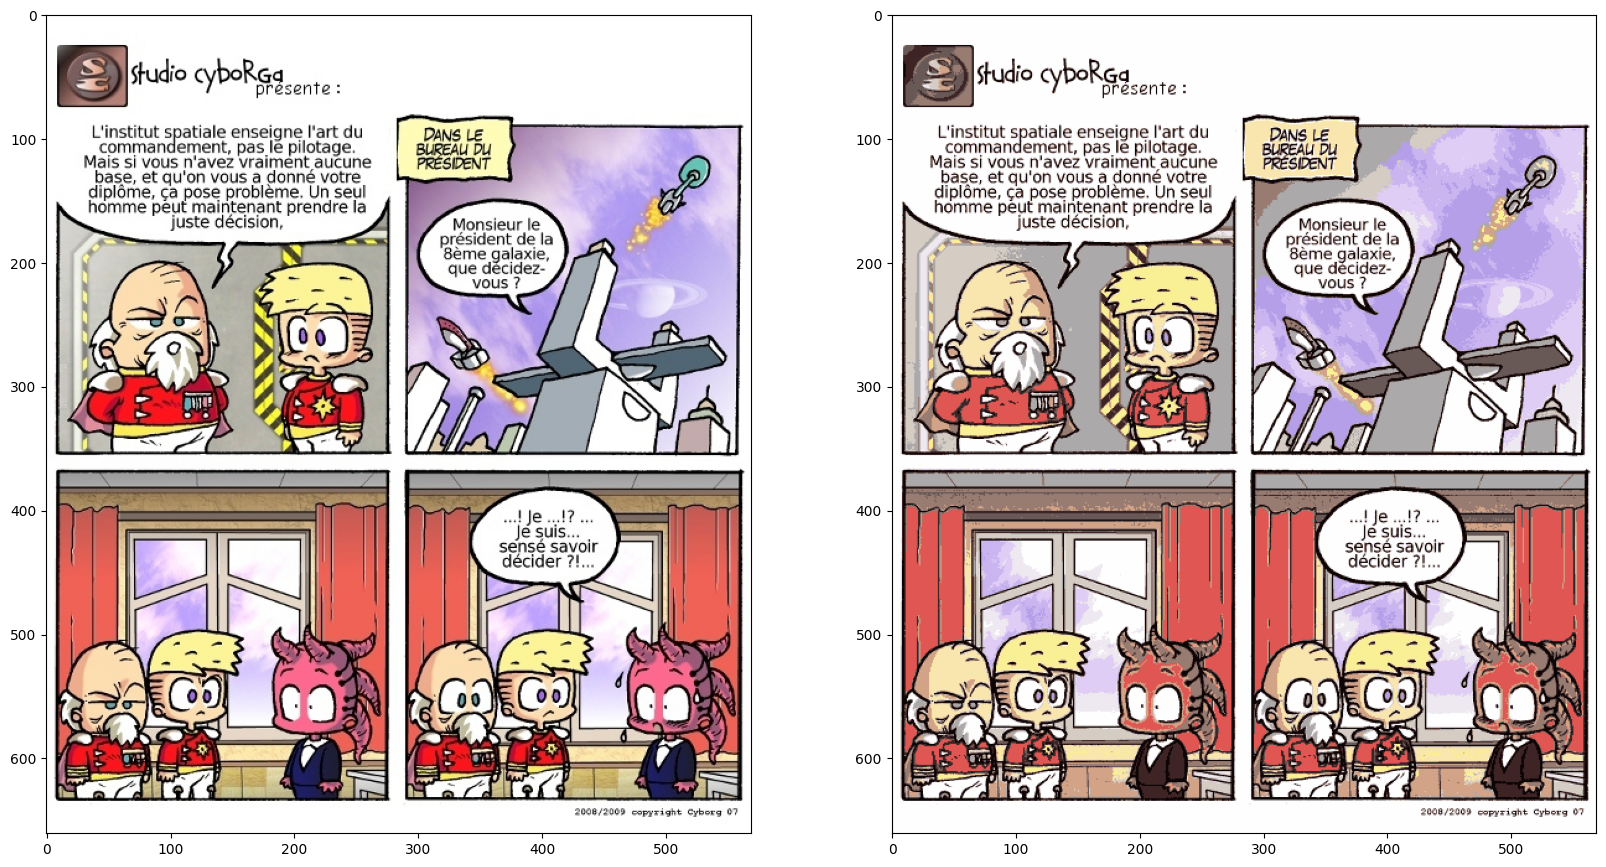

In [82]:
show_img_bbox(image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]], y_image)

#### c = 10

##### fit

In [83]:
model = FuzzyCMeansGaussianS2(num_class=10, epochs=50, threshold=.5, verbose=True)
model.fit(X, None)

epoca: 0 funcão objetivo: 6977.817
epoca: 1 funcão objetivo: 5726.0185546875
epoca: 2 funcão objetivo: 5114.89013671875
epoca: 3 funcão objetivo: 4970.212890625
epoca: 4 funcão objetivo: 4872.2646484375
epoca: 5 funcão objetivo: 4782.5419921875
epoca: 6 funcão objetivo: 4741.5830078125
epoca: 7 funcão objetivo: 4688.5283203125
epoca: 8 funcão objetivo: 4664.83642578125
epoca: 9 funcão objetivo: 4646.6875
epoca: 10 funcão objetivo: 4646.77490234375


In [84]:
model.G

array([[0.99715966, 0.99558674, 0.99655537],
       [0.96356152, 0.89343097, 0.67169127],
       [0.08451597, 0.0361047 , 0.04069947],
       [0.88125097, 0.83327517, 0.91117995],
       [0.34652789, 0.26418104, 0.25833836],
       [0.58194991, 0.48645123, 0.43852099],
       [0.71626266, 0.67772244, 0.64802971],
       [0.88255223, 0.34741713, 0.33454631],
       [0.75260682, 0.67024003, 0.92190298],
       [0.88125097, 0.83327517, 0.91117995]])

In [85]:
model.sigma

array([[1.5811533 , 0.56182957, 1.1256969 ],
       [1.9813977 , 0.94262016, 0.53541636],
       [0.62187195, 1.5564694 , 1.0331382 ],
       [1.5484487 , 1.120306  , 0.5764565 ],
       [0.98648214, 1.0876108 , 0.9320458 ],
       [0.8802392 , 1.0356386 , 1.0969608 ],
       [0.86894816, 1.2534887 , 0.91809106],
       [1.4488797 , 0.8070873 , 0.8551595 ],
       [1.0755279 , 0.94844115, 0.98032016],
       [1.5484487 , 1.120306  , 0.5764565 ]], dtype=float32)

In [86]:
y = model.predict(X)

In [87]:
y_image = (model.G[y].reshape(image_shape_out)*255).astype(np.uint8)

In [88]:
image.shape, y_image.shape

((661, 569, 3), (661, 569, 3))

In [89]:
filename = img_path.split("/")[-1]
set_name = "results/minimal/cmeans/comics/"
model.save_model(f"{set_name}model/10/model.json")

Image.fromarray(y_image).save(f"{set_name}imgs/10/{filename}")
ssim, hssim, q = metricas(image, y_image)
resultados.append([ssim, hssim, q])

SSIM : 0.0040
SSIM entre histogramas: 0.0977
UQI: 0.9817


In [90]:
image[:2, :2], image.astype(np.float32)[:2, :2]

(array([[[255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255]]], dtype=uint8),
 array([[[255., 255., 255.],
         [255., 255., 255.]],
 
        [[255., 255., 255.],
         [255., 255., 255.]]], dtype=float32))

##### show

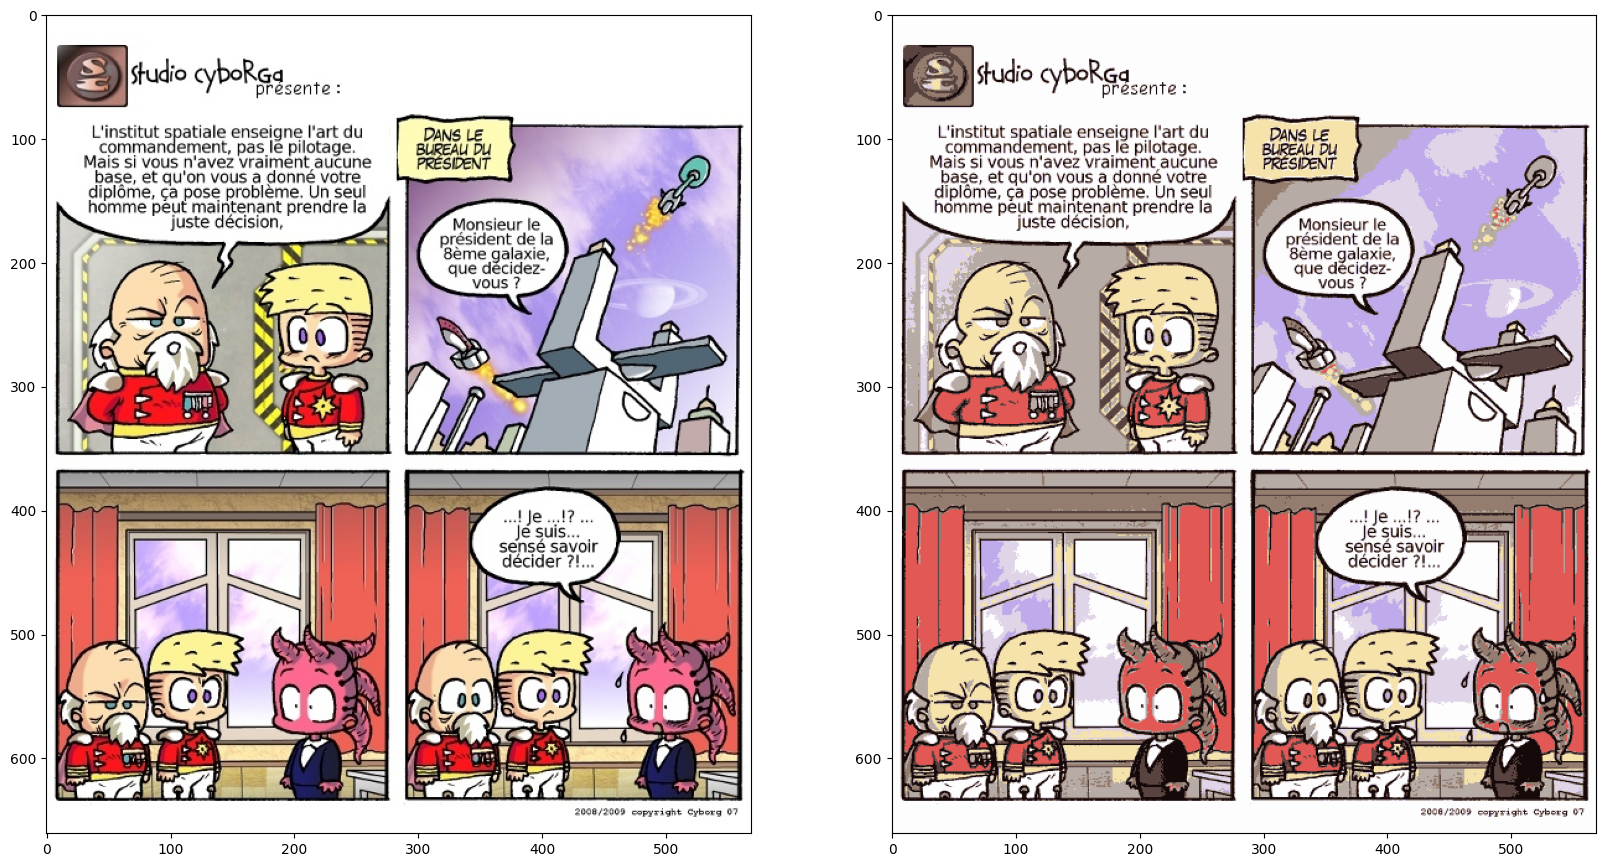

In [91]:
show_img_bbox(image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]], y_image)

In [92]:
# time change
# new row
# new column
# pure grid
# ecs_insert
# whole_row
# whole_column


#### wikiart High_Renaissance leonardo da vinci mona lisa

In [93]:
# from Pill import Image 
from PIL import Image, ImageDraw, ImageFont
import numpy as np

img_path = "./datasets/wikiart/High_Renaissance/leonardo-da-vinci_mona-lisa.jpg"
image_shape_out = 640, 640, 3
img = Image.open(img_path).convert("RGB")
img = img.resize(image_shape_out[:2])
image = np.array(img)
# image_shape_out = image.shape

print(image.shape)
X = image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]].reshape(-1, image_shape_out[2]) /255
print(X.shape)

(640, 640, 3)
(409600, 3)


In [94]:
# image 출력 함수 정의
def show_img_bbox(X, y):
    plt.figure(figsize=(20, 20))
    for i, img in enumerate([X, y]):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)


#### c = 20

##### fit

In [95]:
model = FuzzyCMeansGaussianS2(num_class=20, epochs=50, threshold=.5, verbose=True)
model.fit(X, None)

epoca: 0 funcão objetivo: 1977.2804
epoca: 1 funcão objetivo: 1607.657958984375
epoca: 2 funcão objetivo: 1461.33447265625
epoca: 3 funcão objetivo: 1381.79345703125
epoca: 4 funcão objetivo: 1344.9635009765625
epoca: 5 funcão objetivo: 1327.9259033203125
epoca: 6 funcão objetivo: 1306.786865234375
epoca: 7 funcão objetivo: 1291.9970703125
epoca: 8 funcão objetivo: 1274.5533447265625
epoca: 9 funcão objetivo: 1257.26025390625
epoca: 10 funcão objetivo: 1237.638671875
epoca: 11 funcão objetivo: 1217.24462890625
epoca: 12 funcão objetivo: 1198.8511962890625
epoca: 13 funcão objetivo: 1182.9346923828125
epoca: 14 funcão objetivo: 1169.3414306640625
epoca: 15 funcão objetivo: 1157.018310546875
epoca: 16 funcão objetivo: 1145.144287109375
epoca: 17 funcão objetivo: 1133.52783203125
epoca: 18 funcão objetivo: 1121.59912109375
epoca: 19 funcão objetivo: 1109.202880859375
epoca: 20 funcão objetivo: 1096.0150146484375
epoca: 21 funcão objetivo: 1081.574951171875
epoca: 22 funcão objetivo: 1065.

In [96]:
model.G

array([[0.16995247, 0.08344295, 0.05925519],
       [0.09293609, 0.04537064, 0.04895557],
       [0.2534177 , 0.11443442, 0.06633911],
       [0.3340608 , 0.27471444, 0.11659886],
       [0.64366713, 0.36384197, 0.0922647 ],
       [0.94230795, 0.7410093 , 0.25786237],
       [0.24696233, 0.20395971, 0.09749111],
       [0.07429516, 0.03083715, 0.03432083],
       [0.3407988 , 0.16167537, 0.07405064],
       [0.74695246, 0.62687609, 0.2579422 ],
       [0.1869303 , 0.14213582, 0.07692309],
       [0.12336425, 0.06403876, 0.05503305],
       [0.54422708, 0.46017259, 0.17484838],
       [0.05593926, 0.02002065, 0.02424387],
       [0.43972798, 0.3801764 , 0.14856553],
       [0.4362674 , 0.21872641, 0.07785427],
       [0.64519303, 0.53608997, 0.20413628],
       [0.53917317, 0.28052313, 0.08135381],
       [0.76578135, 0.45789813, 0.1115566 ],
       [0.88918681, 0.58671492, 0.15883834]])

In [97]:
model.sigma

array([[0.7786903 , 0.98582876, 1.302668  ],
       [0.9492052 , 1.276549  , 0.82528204],
       [0.7538412 , 0.8475306 , 1.5651816 ],
       [0.9568455 , 1.1653203 , 0.8968356 ],
       [0.6037369 , 0.64275295, 2.5769632 ],
       [1.2855961 , 0.8683552 , 0.8957731 ],
       [0.9104958 , 0.98197496, 1.118463  ],
       [0.9068151 , 1.2320292 , 0.89507663],
       [0.6825162 , 0.7483328 , 1.9579079 ],
       [0.9724286 , 1.2621357 , 0.81477225],
       [0.87660325, 0.88169646, 1.2938318 ],
       [1.1350136 , 0.87533957, 1.00652   ],
       [0.89901507, 1.4934567 , 0.7448012 ],
       [0.7499449 , 1.4200706 , 0.93898934],
       [1.0775442 , 1.1558313 , 0.8029166 ],
       [0.6655577 , 0.5939347 , 2.5297384 ],
       [0.9503918 , 1.4068859 , 0.74789125],
       [0.5922106 , 0.5805554 , 2.9085743 ],
       [0.63886523, 0.7549257 , 2.0734165 ],
       [1.0240409 , 0.7065904 , 1.3820219 ]], dtype=float32)

In [98]:
y = model.predict(X)

In [99]:
y_image = (model.G[y].reshape(image_shape_out)*255).astype(np.uint8)

In [100]:
filename = img_path.split("/")[-1]
set_name = "results/minimal/cmeans/art/"
model.save_model(f"{set_name}model/20/model.json")

Image.fromarray(y_image).save(f"{set_name}imgs/20/{filename}")
ssim, hssim, q = metricas(image, y_image)
resultados.append([ssim, hssim, q])

SSIM : 0.8744
SSIM entre histogramas: 0.3165
UQI: 0.9933


##### show

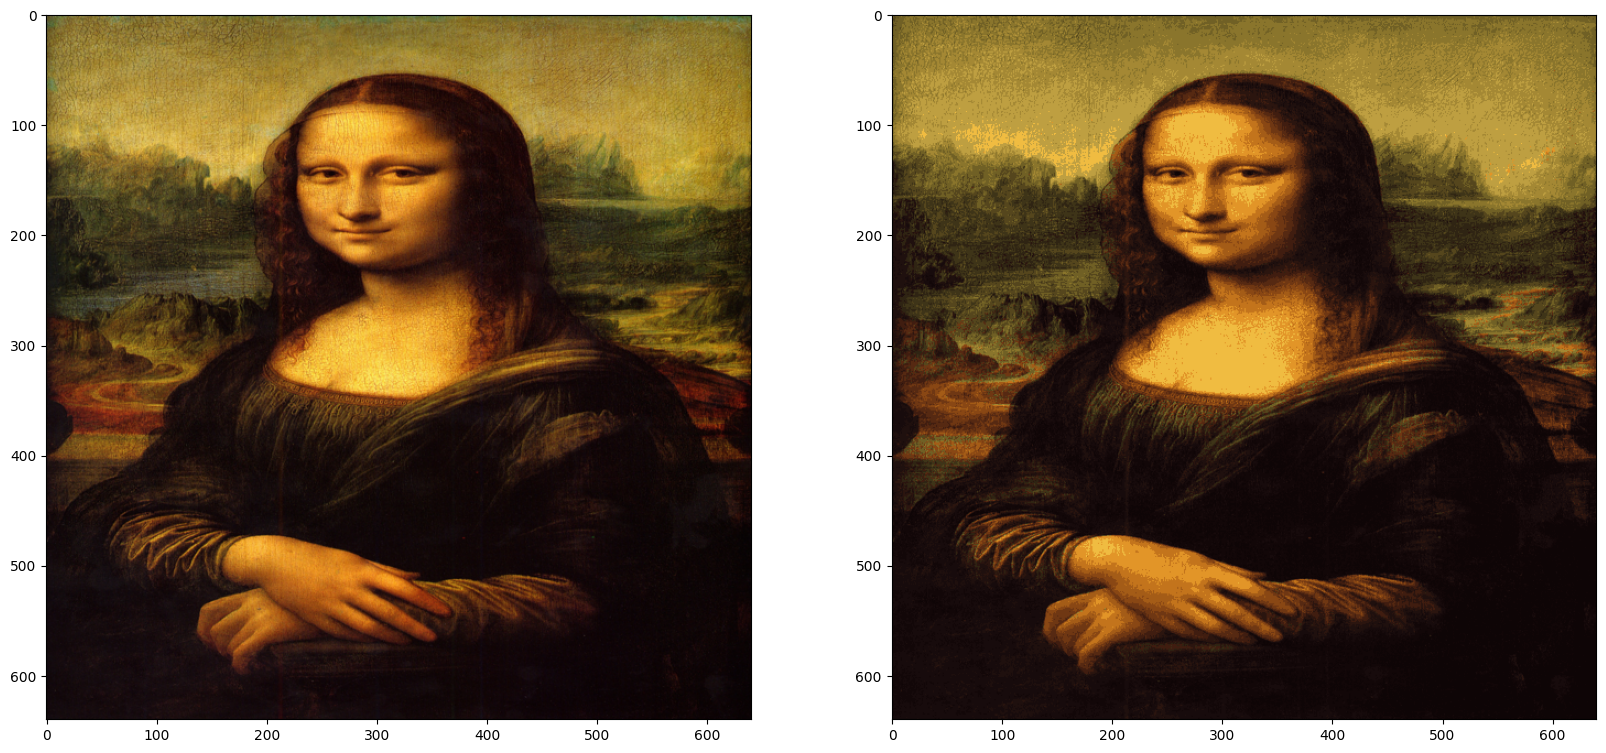

In [101]:
show_img_bbox(image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]], y_image)

#### c = 10

##### fit

In [102]:
model = FuzzyCMeansGaussianS2(num_class=10, epochs=50, threshold=.5, verbose=True)
model.fit(X, None)

epoca: 0 funcão objetivo: 4462.4956
epoca: 1 funcão objetivo: 3556.048583984375
epoca: 2 funcão objetivo: 3580.87841796875
epoca: 3 funcão objetivo: 3398.412841796875
epoca: 4 funcão objetivo: 3216.041015625
epoca: 5 funcão objetivo: 3104.5283203125
epoca: 6 funcão objetivo: 2991.690185546875
epoca: 7 funcão objetivo: 2902.62744140625
epoca: 8 funcão objetivo: 2809.988037109375
epoca: 9 funcão objetivo: 2710.88720703125
epoca: 10 funcão objetivo: 2597.400146484375
epoca: 11 funcão objetivo: 2489.901123046875
epoca: 12 funcão objetivo: 2392.049072265625
epoca: 13 funcão objetivo: 2342.453125
epoca: 14 funcão objetivo: 2260.960205078125
epoca: 15 funcão objetivo: 2253.24853515625
epoca: 16 funcão objetivo: 2164.03564453125
epoca: 17 funcão objetivo: 2195.54833984375
epoca: 18 funcão objetivo: 2092.24267578125
epoca: 19 funcão objetivo: 2159.7236328125
epoca: 20 funcão objetivo: 2036.3763427734375
epoca: 21 funcão objetivo: 2140.244873046875
epoca: 22 funcão objetivo: 1991.2418212890625
e

In [103]:
model.G

array([[0.28818658, 0.20237939, 0.09383692],
       [0.42370292, 0.36226907, 0.14423619],
       [0.42164459, 0.21102535, 0.07745494],
       [0.07205028, 0.03071263, 0.03486701],
       [0.58681115, 0.47057295, 0.17166856],
       [0.12616017, 0.06465337, 0.05451393],
       [0.90945408, 0.69568924, 0.24021735],
       [0.21020564, 0.12239877, 0.07062385],
       [0.73063793, 0.56096845, 0.20135946],
       [0.57975731, 0.30423188, 0.08344015]])

In [104]:
model.sigma

array([[0.8575213 , 0.67807287, 1.7198031 ],
       [0.93392146, 0.99020797, 1.0813423 ],
       [0.5314441 , 0.59517765, 3.1615193 ],
       [0.7580979 , 1.2828302 , 1.0282661 ],
       [0.79653263, 1.2209697 , 1.028233  ],
       [0.71247333, 0.90419626, 1.5522751 ],
       [1.0704226 , 0.8709856 , 1.07259   ],
       [0.6655532 , 0.72269106, 2.0790482 ],
       [0.981288  , 1.063859  , 0.9578984 ],
       [0.449644  , 0.58275616, 3.816316  ]], dtype=float32)

In [105]:
y = model.predict(X)

In [106]:
y_image = (model.G[y].reshape(image_shape_out)*255).astype(np.uint8)

In [107]:
filename = img_path.split("/")[-1]
set_name = "results/minimal/cmeans/art/"
model.save_model(f"{set_name}model/10/model.json")

Image.fromarray(y_image).save(f"{set_name}imgs/10/{filename}")
ssim, hssim, q = metricas(image, y_image)
resultados.append([ssim, hssim, q])
# metricas(image, y_image)

SSIM : 0.8569
SSIM entre histogramas: 0.1717
UQI: 0.9860


##### show

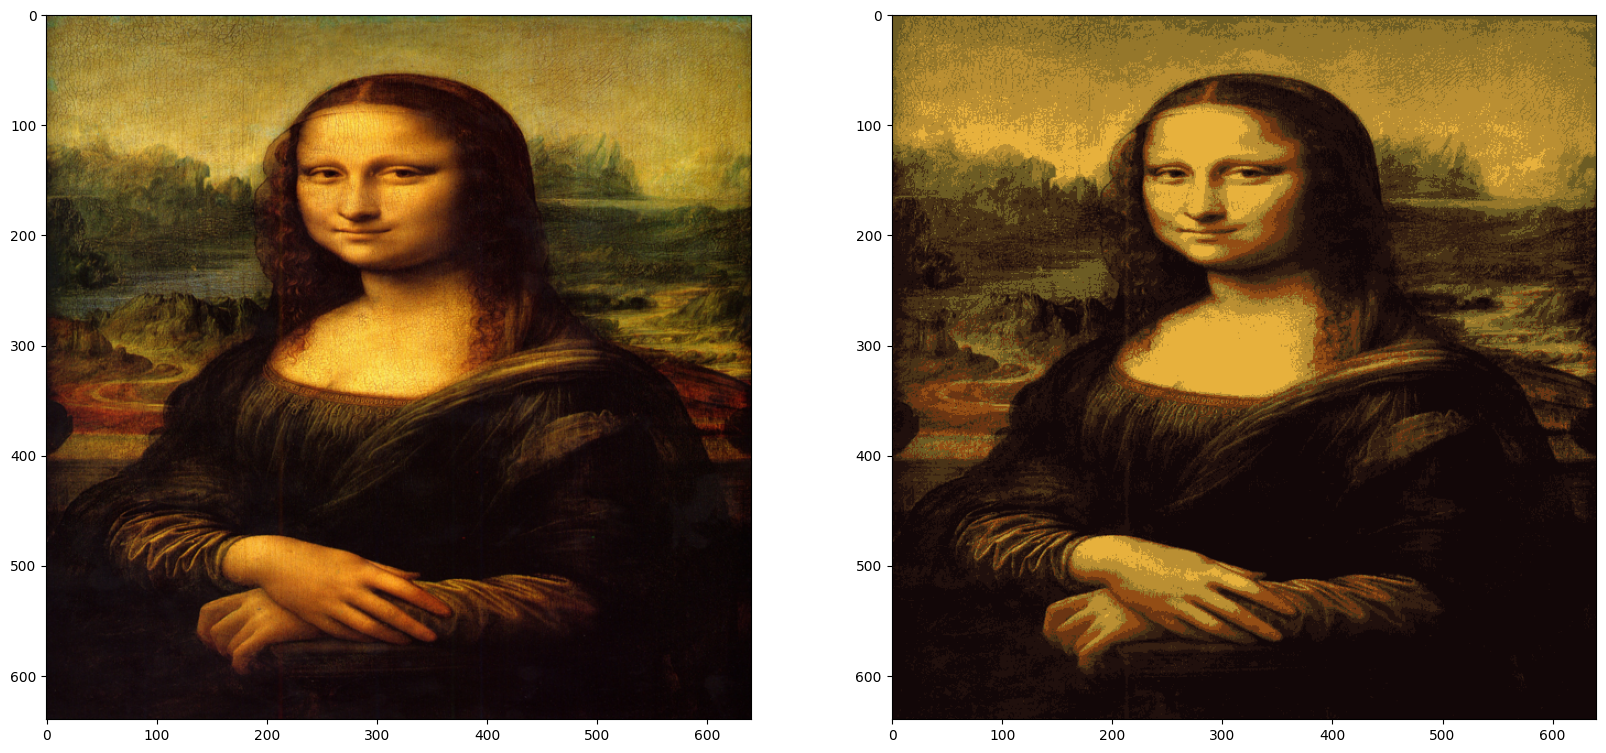

In [108]:
show_img_bbox(image[:image_shape_out[0],\
                     :image_shape_out[1], \
                        :image_shape_out[2]], y_image)

In [109]:
# time change
# new row
# new column
# pure grid
# ecs_insert
# whole_row
# whole_column


In [110]:
pd.DataFrame(
    np.array(resultados).T, index=["ssim", "hssim", "uqi"]
).T.to_csv(f"results/minimal/cmeans/metricas.csv")
print(resultados)

[[0.9999922804363157, 0.13161516821695549, 0.9870719751447303], [0.00403360823309598, 0.09771741841830288, 0.9817138364434803], [0.874379505716684, 0.31645197780642514, 0.9932789481047776], [0.85692450926798, 0.17171945312255585, 0.9859690747248926]]
